In [9]:
import glob
import os
import h5py
import numpy as np
import json
import matplotlib.pyplot as plt

In [14]:
def get_stepsizes(exp_dir):
    with open(os.path.join(exp_dir, "info.json"), "r") as f:
        info = json.load(f)
    stepsizes = info["stepsizes"]
    return stepsizes

def plot_experiments(exp_name, base_dir="/Users/dominic/JuliaProjects/Integrators_for_Multiplicative_Noise/simulation_results/"):
    exp_dir = os.path.join(base_dir, exp_name)
    data_files = glob.glob(os.path.join(exp_dir, "*.h5"))
    stepsizes = get_stepsizes(exp_dir)

    for data_file in data_files:
        integrator_name = os.path.splitext(os.path.basename(data_file))[0]
        # load the .h5 file to a numpy array
        convergence_data = np.array(h5py.File(data_file, 'r')['data'])

        mean_convergence = np.mean(convergence_data, axis=0)
        std_convergence = np.std(convergence_data, axis=0)

        # plot the mean convergence
        plt.plot(stepsizes, mean_convergence, label=integrator_name)
        plt.fill_between(stepsizes, mean_convergence - std_convergence,
                        mean_convergence + std_convergence, alpha=0.3)
        
    plt.legend()
    plt.ylabel("Mean L1 Error, invariant measure")
    plt.xlabel("Stepsize, h")
    plt.yscale('log')
    plt.xscale('log')

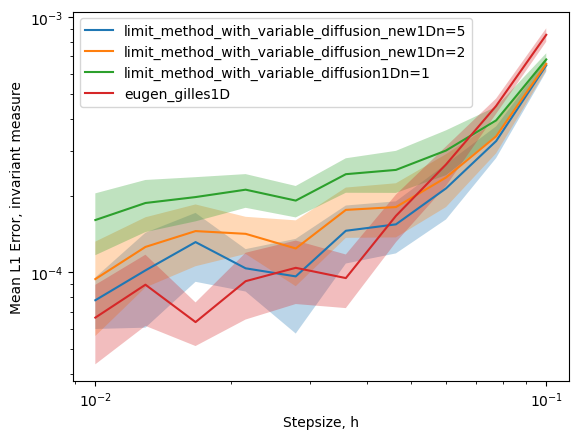

In [15]:
plot_experiments("eugen_gilles_cos_LMVD_1D_100K")